### Build an MLP with residual connections for ECG Signal Classification (5 classes)  - Pytorch

### Read H4P2_torchview.ipynb first

In [1]:
#Create your "signature"
#Run this cell but do NOT modify the code.
#The signature needs to be displayed right below the cell in this file.
#You will get zero point if the signature is not displayed.     
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature=[socket.gethostbyname(socket.gethostname()),
           getpass.getuser(),
           datetime.now(),
           random.random()]
print(signature) 

['127.0.0.1', 'sloanatkins', datetime.datetime(2025, 11, 24, 12, 13, 2, 855140), 0.7521773984932086]


In [2]:
#do not modify this cell
import os
import numpy as np
np.random.seed(seed=None)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim
import platform, socket, getpass
from time import time
from datetime import datetime

### Design an MLP -  modify the cell below

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #-------------------------------------------Instructions------------------------------------------
        # replace each * with a suitable layer according to the diagram in Homework4.pdf
        #   for example: change self.linear1 = * to self.linear1=nn.Linear(in_features=?, out_features=?)
        # replace each ? with a suitable value
        #   for example: change in_features=? to in_features=187 in self.linear1
        # do NOT replace/change anything eslse
        # do NOT add new layers        
        #--------------------------------------------------------------------------------------------------

        self.linear1 = nn.Linear(187, 128)
        self.linear2 = nn.Linear(128, 128)

        self.norm3 = nn.LayerNorm(normalized_shape=128)
        self.linear3 = nn.Linear(128, 128)

        self.norm4 = nn.LayerNorm(normalized_shape=128)
        self.linear4 = nn.Linear(128, 128)

        self.norm5 = nn.LayerNorm(normalized_shape=128)
        self.linear5 = nn.Linear(128, 128)

        self.linear6 = nn.Linear(128, 5) 
                
    def forward(self, x):
        #-----------------Instructions---------------------------------
        #connect the layers according to the diagram in Homework4.pdf
        #ReLU in the diagram refers to nnF.relu, which is used here
        #use variable names according to the diagram in Homework4.pdf
        #    for example  x1=nnF.relu(self.linear(x))        
        #to debug you code: print the shape of the output from every layer
        #    for example: print("x1", x1.shape)
        #--------------------------------------------------------------
        x1 = nnF.relu(self.linear1(x))

        x2 = nnF.relu(self.linear2(x1))

        x3 = nnF.relu(self.linear3(self.norm3(x2)))

        x4 = nnF.relu(self.linear4(self.norm4(x3)))

        x5 = nnF.relu(self.linear5(self.norm5(x4)))

        z = self.linear6(x5)
        return z

In [4]:
#debug your network here
model=Net()
x=torch.rand(10,187)
z=model(x)
print(z.shape) # (10, 5)

torch.Size([10, 5])


### Read and Run, but do NOT modify any code below this line
### You may get zero score if you modify any code below this line

In [5]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

## The function to train the model

In [6]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2)
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max               
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset) 
    acc_train/=sample_count    
    return loss_train, acc_train

## The Function to test the model

In [7]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5), dtype=np.int64)
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max 
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

In [8]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result,
                'other':[platform.node(), 
                         socket.gethostbyname(socket.gethostname()), 
                         getpass.getuser(),
                         datetime.now(),
                         np.random.rand()]},
               filename)
    print('saved:', filename)

## Load data and create dataloaders

In [9]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        return x, y

In [10]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [11]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [12]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [13]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

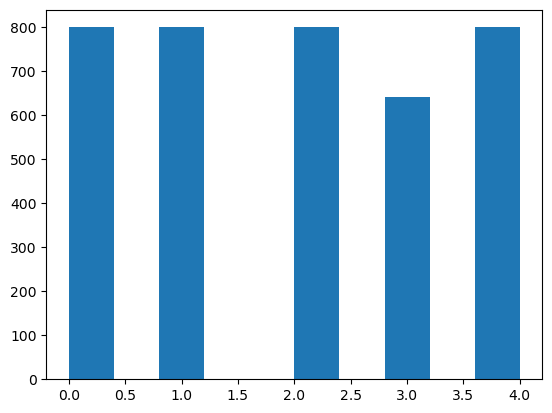

In [14]:
plt.hist(Y)

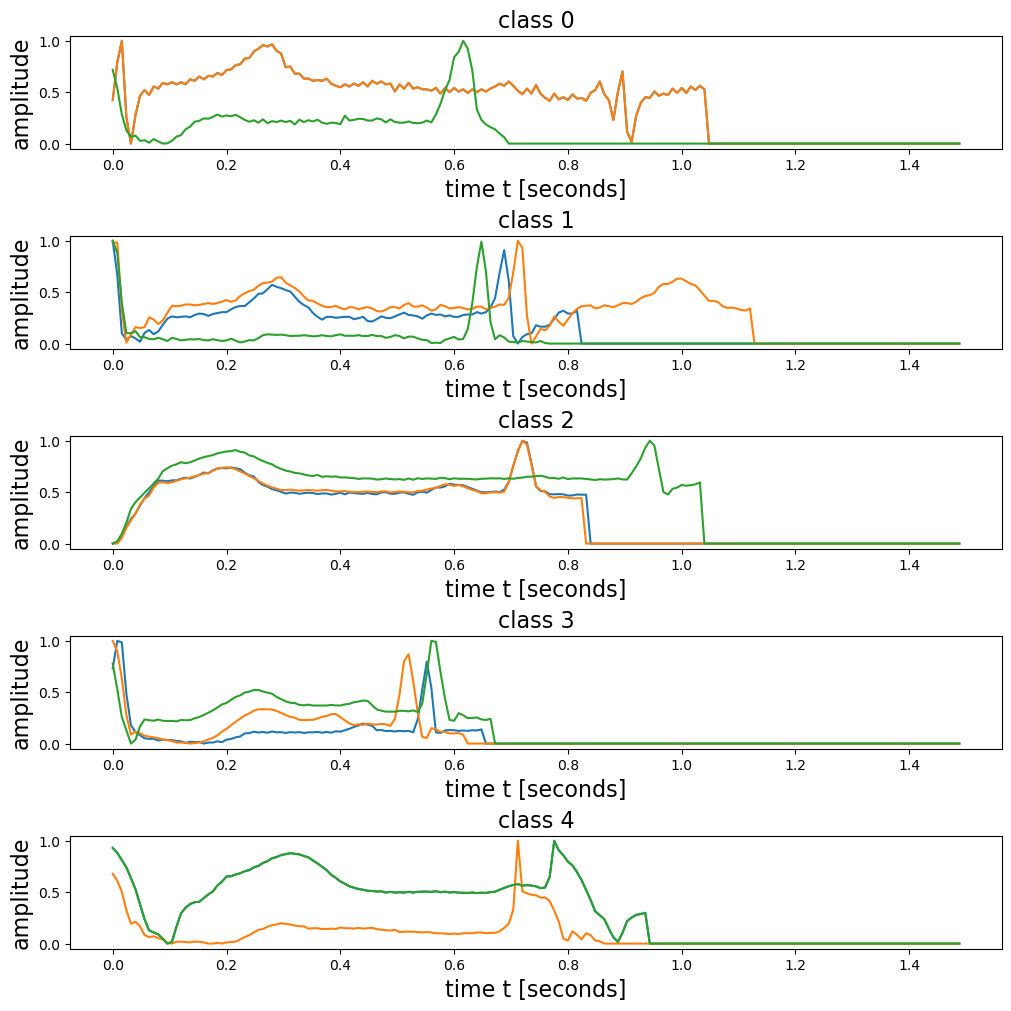

In [15]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [17]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [18]:
#use a smaller batch_size if necessary
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

## Create a model, and start the traning-validation-testing process

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
x=dataset_train[0][0]
x=x.view(1,187).to(device)
z=model(x)

In [20]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.2325, 0.2853, 0.1372, 0.1466, 0.1983]], grad_fn=<SoftmaxBackward0>)

choose an optimization method

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

In [22]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
val_acc_best=0

train/val/test over many epochs

In [23]:
for epoch in range(0, 100): 
    t0=time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    if acc_val > val_acc_best:
        val_acc_best=acc_val
        result = (loss_train_list, acc_train_list, 
                  acc_val_list, other_val)
        save_checkpoint('H4P2T1_MLP_best.pt', model, optimizer, result, epoch)    
    t1=time()
    print('epoch', epoch, 'time cost:', t1-t0)

Train Epoch: 0 [0%]	Loss: 1.596064
epoch 0 training loss: 1.0503889132629742 acc: 0.5900868306801736
epoch 0 validation acc: 0.72402596
saved: H4P2T1_MLP_best.pt
epoch 0 time cost: 0.11005306243896484
Train Epoch: 1 [0%]	Loss: 0.631375
epoch 1 training loss: 0.6716882681304758 acc: 0.75
epoch 1 validation acc: 0.7467533
saved: H4P2T1_MLP_best.pt
epoch 1 time cost: 0.05451488494873047
Train Epoch: 2 [0%]	Loss: 0.623454
epoch 2 training loss: 0.550569702278484 acc: 0.7999276410998553
epoch 2 validation acc: 0.77272725
saved: H4P2T1_MLP_best.pt
epoch 2 time cost: 0.0551609992980957
Train Epoch: 3 [0%]	Loss: 0.452435
epoch 3 training loss: 0.462457230145281 acc: 0.8267004341534009
epoch 3 validation acc: 0.8181818
saved: H4P2T1_MLP_best.pt
epoch 3 time cost: 0.06139969825744629
Train Epoch: 4 [0%]	Loss: 0.356286
epoch 4 training loss: 0.42543530057777057 acc: 0.8455137481910275
epoch 4 validation acc: 0.8116883
epoch 4 time cost: 0.05617213249206543
Train Epoch: 5 [0%]	Loss: 0.358339
epoch

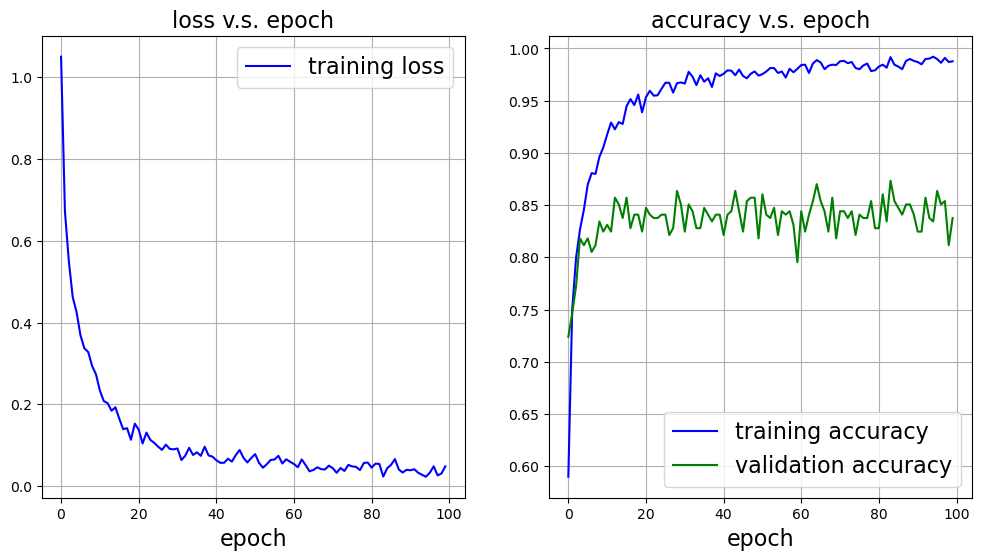

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [25]:
best_epoch=np.argmax(acc_val_list)
best_epoch

np.int64(83)

In [26]:
checkpoint=torch.load('H4P2T1_MLP_best.pt', weights_only=False)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [27]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.90247077
Sensitivity [0.84090906 0.88961041 0.93150687 0.91803277 0.94152045]
Precision [0.87058824 0.85624999 0.90066224 0.91803277 0.96987951]
Confusion 
 [[148  16   7   3   2]
 [ 10 137   4   2   1]
 [  3   1 136   4   2]
 [  6   2   2 112   0]
 [  3   4   2   1 161]]


### You will get zero score if the test accuracy < 80%

In [28]:
if acc < 0.8:
    print("zero point for this task")
else:
    print("good job")

good job


### submit this ipynb file and H4P2T1_MLP_best.pt if acc >= 0.8